In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fids30/FIDS30/links.txt
/kaggle/input/fids30/FIDS30/fruits.txt
/kaggle/input/fids30/FIDS30/strawberries/45.jpg
/kaggle/input/fids30/FIDS30/strawberries/20.jpg
/kaggle/input/fids30/FIDS30/strawberries/6.jpg
/kaggle/input/fids30/FIDS30/strawberries/8.jpg
/kaggle/input/fids30/FIDS30/strawberries/38.jpg
/kaggle/input/fids30/FIDS30/strawberries/42.jpg
/kaggle/input/fids30/FIDS30/strawberries/33.jpg
/kaggle/input/fids30/FIDS30/strawberries/10.jpg
/kaggle/input/fids30/FIDS30/strawberries/54.jpg
/kaggle/input/fids30/FIDS30/strawberries/0.jpg
/kaggle/input/fids30/FIDS30/strawberries/41.jpg
/kaggle/input/fids30/FIDS30/strawberries/9.jpg
/kaggle/input/fids30/FIDS30/strawberries/37.jpg
/kaggle/input/fids30/FIDS30/strawberries/1.jpg
/kaggle/input/fids30/FIDS30/strawberries/46.jpg
/kaggle/input/fids30/FIDS30/strawberries/29.jpg
/kaggle/input/fids30/FIDS30/strawberries/16.jpg
/kaggle/input/fids30/FIDS30/strawberries/55.jpg
/kaggle/input/fids30/FIDS30/strawberries/23.jpg
/kaggle/input/fi

# Imports

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
from random import randint
from sklearn.metrics import f1_score
from tensorflow import keras
from keras.models import load_model
from keras import layers
from keras import Sequential
from keras import activations
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop, AdamW,Adadelta, Adagrad, Adamax,Nadam 
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from random import randint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score
import time
import keras_tuner as kt
from collections import Counter
import numpy as np
import pandas as pd
from pandas import DataFrame
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
tf.test.is_built_with_cuda()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


True

# Custom Fns

In [5]:
def get_directory_names(folder_path):
    try:
        # Get a list of all files and directories in the specified folder
        contents = os.listdir(folder_path)
        
        # Filter out only the directories
        directories = [item for item in contents if os.path.isdir(os.path.join(folder_path, item))]
        directories.sort()
        return directories
    except OSError as e:
        print(f"Error: {e}")
        return []

def get_run_logdir(root_logdir):
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

def plot_acc(history):
    """
        plots the history of the Model giving the accuracy of tranning and validation.
    """
    plt.figure(figsize=(20,20))
    # Plotting the trainning and validation accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting the trainning and validation loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Models Builders

## VGG16

In [6]:
def vgg16_builder(number_of_classes,input_shape):
    base_model = keras.applications.VGG16(include_top = False,
                                          weights = 'imagenet',
                                          pooling='avg',
                                          input_shape = input_shape)
    base_model.trainable = False
    x = base_model.output
    predictions = keras.layers.Dense(number_of_classes,activation='softmax')(x)
    model = keras.Model(inputs=base_model.input,outputs=predictions)
    return model

## VGG19

In [7]:
def vgg19_builder(number_of_classes,input_shape):
    base_model = keras.applications.VGG19(include_top = False,
                                          weights = 'imagenet',
                                          pooling='avg',
                                          input_shape = input_shape)
    base_model.trainable = False
    x = base_model.output
    predictions = keras.layers.Dense(number_of_classes,activation='softmax')(x)
    model = keras.Model(inputs=base_model.input,outputs=predictions)
    return model

# HyperModels

## VGG16

In [8]:
def vgg16_adam_builder(hp):
    vgg16 = vgg16_builder(30,(224,224,3))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_beta_1 = hp.Float('beta_1',min_value=0.9,max_value=1)
    hp_beta_2 = hp.Float('beta_2',min_value=0.9,max_value=1)
    vgg16.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate = hp_learning_rate,
            beta_1 = hp_beta_1,
            beta_2 = hp_beta_2),
        loss = keras.losses.CategoricalCrossentropy(),
        metrics = ['accuracy'])
    return vgg16

In [9]:
def vgg16_sgd_builder(hp):
    vgg16 = vgg16_builder(30,(224,224,3))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3, 1e-4,1e-5])
    hp_momentum = hp.Float("momentum",min_value=0,max_value=1)
    hp_nesterov = hp.Boolean('nesterov')
    hp_weight_decay = hp.Float('weight_decay',min_value=0,max_value=1)
    vgg16.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate,
                                                 momentum=hp_momentum,
                                                 nesterov=hp_nesterov,
                                                 weight_decay=hp_weight_decay),
                 loss=keras.losses.CategoricalCrossentropy(),
                 metrics=['accuracy'])
    return vgg16

## VGG19

In [10]:
def vgg19_adam_builder(hp):
    vgg19 = vgg19_builder(30,(224,224,3))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_beta_1 = hp.Float('beta_1',min_value=0.9,max_value=1)
    hp_beta_2 = hp.Float('beta_2',min_value=0.9,max_value=1)
    vgg19.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate = hp_learning_rate,
            beta_1 = hp_beta_1,
            beta_2 = hp_beta_2),
        loss = keras.losses.CategoricalCrossentropy(),
        metrics = ['accuracy'])
    return vgg19

In [11]:
def vgg19_sgd_builder(hp):
    vgg19 = vgg19_builder(30,(224,224,3))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3, 1e-4,1e-5])
    hp_momentum = hp.Float("momentum",min_value=0,max_value=1)
    hp_nesterov = hp.Boolean('nesterov')
    hp_weight_decay = hp.Float('weight_decay',min_value=0,max_value=1)
    vgg19.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate,
                                                 momentum=hp_momentum,
                                                 nesterov=hp_nesterov,
                                                 weight_decay=hp_weight_decay),
                 loss=keras.losses.CategoricalCrossentropy(),
                 metrics=['accuracy'])
    return vgg19

# Paths of our Data

In [12]:
train_dataset_path = r"/kaggle/input/fids30/FIDS30"
classes = get_directory_names(train_dataset_path)
print(classes)
numberOfClasses = len(classes)
print("Number of Classes:", numberOfClasses)
rootDir = r"/kaggle/working/logs/"
run_logdir = get_run_logdir(rootDir)
print(run_logdir)

tensorboard_cb = TensorBoard(run_logdir)

batch_size = 32
img_width = img_height = 224

['acerolas', 'apples', 'apricots', 'avocados', 'bananas', 'blackberries', 'blueberries', 'cantaloupes', 'cherries', 'coconuts', 'figs', 'grapefruits', 'grapes', 'guava', 'kiwifruit', 'lemons', 'limes', 'mangos', 'olives', 'oranges', 'passionfruit', 'peaches', 'pears', 'pineapples', 'plums', 'pomegranates', 'raspberries', 'strawberries', 'tomatoes', 'watermelons']
Number of Classes: 30
/kaggle/working/logs/run_2023_12_15-12_42_58


# Data Generators.

In [13]:
trainGenerator = ImageDataGenerator(
        rescale=1/255,          # Normalization (between 0 , 1)
        validation_split=0.2,   # Validation Split (10%)
        rotation_range=20,      # randomly rotating the image by 30 degrees (agumentation)
        width_shift_range=0.2,  # shift the width of the image by 20% (agumentation)
        height_shift_range=0.2, # shift the height of the image by 20%  (agumentation)
        horizontal_flip=True    # randomly flip the image horizontally  (agumentation)
        )
testGenerator = ImageDataGenerator(
    rescale = 1/255             # Normalization
)

In [14]:
train_dataset = trainGenerator.flow_from_directory(
    train_dataset_path,
    batch_size=batch_size,
    target_size = (img_height, img_width),
    shuffle=True,
    class_mode='categorical',
    subset="training")
val_dataset = trainGenerator.flow_from_directory(
    train_dataset_path,
    batch_size=batch_size,
    target_size = (img_height,img_width),
    shuffle=True,
    class_mode='categorical',
    subset="validation")

Found 789 images belonging to 30 classes.
Found 182 images belonging to 30 classes.


In [15]:
train_dataset.class_indices

{'acerolas': 0,
 'apples': 1,
 'apricots': 2,
 'avocados': 3,
 'bananas': 4,
 'blackberries': 5,
 'blueberries': 6,
 'cantaloupes': 7,
 'cherries': 8,
 'coconuts': 9,
 'figs': 10,
 'grapefruits': 11,
 'grapes': 12,
 'guava': 13,
 'kiwifruit': 14,
 'lemons': 15,
 'limes': 16,
 'mangos': 17,
 'olives': 18,
 'oranges': 19,
 'passionfruit': 20,
 'peaches': 21,
 'pears': 22,
 'pineapples': 23,
 'plums': 24,
 'pomegranates': 25,
 'raspberries': 26,
 'strawberries': 27,
 'tomatoes': 28,
 'watermelons': 29}

# Visualzation

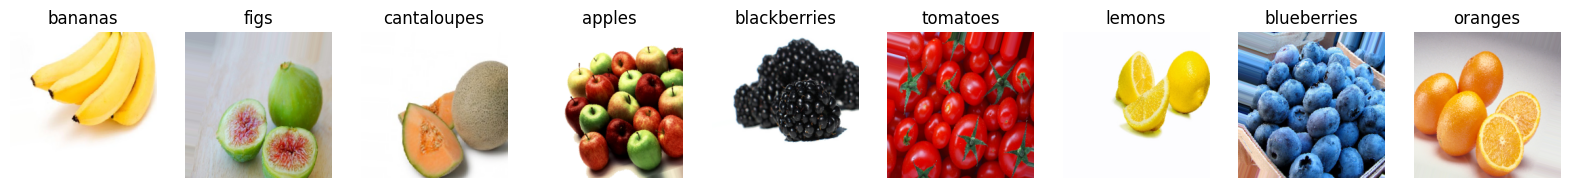

In [16]:
images, labels = train_dataset.next()

fig, axes = plt.subplots(figsize=(20,20), ncols=9)
for i in range(9):
    ax = axes[i]
    label = np.argwhere(labels[i] == 1)[0][0]
#     label = labels[i]
#     print(label)
    title= classes[label]
    ax.imshow(images[i])
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

# Callback Functions

In [17]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5)

vgg16_checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/Checkpoint/VGG16/checkpoint',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
)

vgg19_checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/Checkpoint/VGG19/checkpoint',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
)


# HyperParameter Tuning

## Bayesian Optimization

In [18]:
vgg16_adam_tuner = kt.BayesianOptimization(
    vgg16_adam_builder,
    objective='val_accuracy',
    max_trials=10,
    directory=r"/kaggle/working/model_builds/",
    project_name='BayesianOptimizationVgg19')
vgg16_sgd_tuner = kt.BayesianOptimization(
    vgg16_sgd_builder,
    objective='val_accuracy',
    max_trials=10,
    directory=r"/kaggle/working/model_builds/",
    project_name='BayesianOptimizationVgg16SGD')

In [19]:
vgg16_adam_tuner.search(train_dataset,epochs=50,validation_data=val_dataset,callbacks=[stop_early])

In [20]:
vgg16_sgd_tuner.search(train_dataset,epochs=50,validation_data=val_dataset,callbacks=[stop_early])

## HyperBand

In [21]:
vgg16_adam_hyperband_tuner = kt.Hyperband(vgg16_adam_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='model_builds',
                     project_name='HyperBand-Adam-VGG16')

In [22]:
vgg16_sgd_hyperband_tuner = kt.Hyperband(vgg16_sgd_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='model_builds',
                     project_name='HyperBand-SGD-VGG16')

In [23]:
vgg16_adam_hyperband_tuner.search(train_dataset,epochs=50,validation_data=val_dataset,callbacks=[stop_early])

In [24]:
vgg16_sgd_hyperband_tuner.search(train_dataset,epochs=50,validation_data=val_dataset,callbacks=[stop_early])

# Final Models

# Default Adam

In [ ]:
vgg16_model = vgg16_builder(30,(224,224,3))
vgg16_model.compile(
        optimizer=keras.optimizers.Adam(),
        loss = keras.losses.CategoricalCrossentropy(),
        metrics = ['accuracy'])
vgg16_history_deafult = vgg16_model.fit(train_dataset,epochs=25,validation_data=val_dataset,callbacks=[vgg16_checkpoint,stop_early,tensorboard_cb])

Epoch 1/25
25/25 [==============================] - 27s 1s/step - loss: 3.4564 - accuracy: 0.0330 - val_loss: 3.2682 - val_accuracy: 0.1374
Epoch 2/25
25/25 [==============================] - 25s 997ms/step - loss: 3.2328 - accuracy: 0.1508 - val_loss: 3.1370 - val_accuracy: 0.1813
Epoch 3/25
25/25 [==============================] - 25s 1s/step - loss: 3.0978 - accuracy: 0.2256 - val_loss: 3.0210 - val_accuracy: 0.2582
Epoch 4/25
25/25 [==============================] - 25s 990ms/step - loss: 2.9689 - accuracy: 0.2966 - val_loss: 2.9122 - val_accuracy: 0.3407
Epoch 5/25
25/25 [==============================] - 25s 989ms/step - loss: 2.8604 - accuracy: 0.3599 - val_loss: 2.8107 - val_accuracy: 0.3516
Epoch 6/25
25/25 [==============================] - 25s 1s/step - loss: 2.7625 - accuracy: 0.4119 - val_loss: 2.7338 - val_accuracy: 0.4121
Epoch 7/25
25/25 [==============================] - 25s 992ms/step - loss: 2.6648 - accuracy: 0.4563 - val_loss: 2.6693 - val_accuracy: 0.3791
Epoch 8/

In [76]:
v_history = v.fit(train_dataset,epochs=5,validation_data=val_dataset,callbacks=[vgg16_checkpoint, stop_early,tensorboard_cb])

Epoch 1/5
25/25 [==============================] - 27s 1s/step - loss: 3.4799 - accuracy: 0.0418 - val_loss: 3.3075 - val_accuracy: 0.1209
Epoch 2/5
25/25 [==============================] - 24s 956ms/step - loss: 3.2334 - accuracy: 0.1572 - val_loss: 3.1661 - val_accuracy: 0.2033
Epoch 3/5
25/25 [==============================] - 25s 1s/step - loss: 3.1015 - accuracy: 0.2231 - val_loss: 3.0405 - val_accuracy: 0.2473
Epoch 4/5
25/25 [==============================] - 25s 984ms/step - loss: 2.9805 - accuracy: 0.2750 - val_loss: 2.9374 - val_accuracy: 0.3022
Epoch 5/5
25/25 [==============================] - 31s 1s/step - loss: 2.8725 - accuracy: 0.3536 - val_loss: 2.8329 - val_accuracy: 0.3681


In [37]:
vgg19.compile(optimizer=Adam(),
              loss=CategoricalCrossentropy(),
              metrics='accuracy')

In [39]:
vgg16.compile(optimizer=Adam(),
             loss=CategoricalCrossentropy(),
             metrics='accuracy')

In [40]:
vgg16_history = vgg16.fit(train_dataset,
                          epochs=5,
                          validation_data=val_dataset,
                          callbacks=[vgg16_checkpoint, stop_early,tensorboard_cb])

Epoch 1/5
25/25 [==============================] - 51s 2s/step - loss: 3.6132 - accuracy: 0.0355 - val_loss: 3.4065 - val_accuracy: 0.0495
Epoch 2/5
 7/25 [=======>......................] - ETA: 14s - loss: 3.4128 - accuracy: 0.0312

KeyboardInterrupt: 

In [ ]:
tuner = keras_tuner.BayesianOptimization()

In [36]:
vgg19_history = vgg19.fit(train_dataset,
                          epochs=5,
                          validation_data=val_dataset,
                          callbacks=[vgg19_checkpoint, stop_early,tensorboard_cb])

Epoch 1/5
28/28 [==============================] - 53s 1s/step - loss: 3.4331 - accuracy: 0.0293 - val_loss: 3.3960 - val_accuracy: 0.0476
Epoch 2/5
28/28 [==============================] - 26s 922ms/step - loss: 3.3965 - accuracy: 0.0383 - val_loss: 3.3900 - val_accuracy: 0.0476
Epoch 3/5
28/28 [==============================] - 28s 974ms/step - loss: 3.3918 - accuracy: 0.0406 - val_loss: 3.3884 - val_accuracy: 0.0476
Epoch 4/5
28/28 [==============================] - 26s 898ms/step - loss: 3.3917 - accuracy: 0.0417 - val_loss: 3.3854 - val_accuracy: 0.0476
Epoch 5/5
28/28 [==============================] - 26s 918ms/step - loss: 3.3908 - accuracy: 0.0474 - val_loss: 3.3857 - val_accuracy: 0.0476
